# Problema 1: Optimización Multi objetivo en Distribución de Recursos para Misión Humanitaria

## 1. Formulación del Modelo Multiobjetivo

### Conjuntos

### Conjuntos

* Identificador de cada recurso 

$$ I\in \left[Alimentos\:basicos,\:Medicinas,\:Equipos\:medicos,\:Agua\:potable,\:Mantas\right] $$

* Identificador de cada avion disponible

$$ J\in \left[1,\:2,\:3,\:4\right] $$

* Identificador de cada zona de destino 

$$ K\in \left[A,\:B,\:C,\:D\right] $$

* Identificador de viaje por avion 

$$ V\in \left[0,\:1,\:2\right] $$

### Parametros

* Valor de impacto de cada recurso (USD/TON)

$$ VI_i $$

* Peso de cada recurso (TON/unidad)

$$ P_i $$

* Volumen de cada recurso ($m^3$/unidad)

$$ V_i $$

* Diponibilidad de cada recurso (Unidad)

$$ D_i $$

* Peso que puede soportar un avion (TON)

$$ CP_j $$

* Capacidad que tiene un avion ($m^3$)

$$ CV_j $$

* Coste fijo por uso de un avion (USD)

$$ CF_j $$

* Costo variable por el uso de un avion (USD/Km)

$$ CK_j $$

* costo de una zona (Km)

$$ DZ_k $$

* Poblacion de una zona (Miles)

$$ N_k $$

* Multiplicador de impacto de una zona 

$$ MI_k $$

* Necesidad minima de un recurso en una zona 

$$ N_{i,k} $$

### Variables de decision 

* Cantidad de recurso $ i $ transportada en el avion $ j $ en el viaje $ v $ a la zona $ k $ 

$$ x_{i,j,v,k}\in Z^+ $$

* Variable binaria que indica si un avion $ j $ hace un viaje $ v $ en una zona $ k $ 

$$ y_{j,v,k}\in \left[0,\:1\right] $$

* Variables binaria que indica si un avion $ j $ es utilizado 

$$ z_j=\left[0,\:1\right] $$

* Variable binaria que indica la presencia de un recurso $ i $ en el avion $ j $ en un viaje $ v $ 

$$ p_{i,j,v}=\left[0,\:1\right] $$

* Cantidad de unidades de equipos medicos transportadas por el avion $ j $ en el viaje $ v $ a lazona $ k $

$$ n_{j,v,k}\in Z^+ $$

### Funciones objetivo 

* Calculo de valor de impacto social 

$$ \sum _{i\in Recursos}\sum _{j\in Aviones}\sum _{v\in Viajes}\sum _{k\in Zonas}VI_i\cdot x_{i,j,v,k}\cdot MI_k $$

* Calculo de costo total de transporte

$$ \sum _{j\in Aviones}CF_j\cdot z_j+\sum _{j\in Aviones}\:\sum _{v\in Viajes}\:\sum _{k\in Zonas}CK_j\cdot D_k\cdot y_{j,v,k} $$

### Restricciones

1. Indivisibilidad de Equipos Médicos

$$ x_{Equipos\:medicos,j,v,k}=0,3\cdot n_{j,v,k},\:\forall j\in J,\:\forall v\in V,\:\forall k\in V $$

2. Disponibilidad total por recurso

$$ \sum _{j\in J}\sum _{v\in V}\sum _{k\in K}x_{i,j,v,k}\le D_i,\:\forall i\in I $$

3. Satisfacción mínima de demanda por zona

$$ \sum _{j\in J}\sum _{v\in V}x_{i,j,v,k}\ge N_{i,k},\:\forall i\in I,\:\forall k\in K $$

4. Capacidad de peso por avión y por viaje 

$$ \sum _{i\in I}P_i\cdot x_{i,j,v,k}\le CP_j\cdot y_{j,v,k},\:\forall j\in J,\:\forall v\in V,\:\forall k\in K $$

5. Capacidad de volumen por avión y por viaje 

$$ \sum _{i\in I}V_i\cdot x_{i,j,v,k}\le CV_j\cdot y_{j,v,k},\:\forall j\in J,\:\forall v\in V,\:\forall k\in K $$

6. Un avión visita como máximo una zona por viaje 

$$ \sum _{k\in K}y_{j,v,k}\le 1,\:\forall j\in J,\:\forall v\in V $$

7. Máximo 2 viajes por avión y coherencia con uso del avión

$$ \sum _{v\in V}\sum _{k\in K}y_{j,v,k}\le 2\cdot z_j\:\wedge \:z_j\le \sum _{v\in V}\sum _{k\in K}y_{j,v,k},\:\forall j\in J\: $$

8. Seguridad: Medicinas no pueden transportarse en el avión 1

$$ x_{Medicinas,1,v,k}=0 $$

9. Compatibilidad: Agua y Equipos Médicos no pueden viajar juntos

$$ p_{Agua\:potable,j,v}+p_{Equipos\:medicos,j,v}\le 1,\:\forall j\in J,\:\forall v\in V $$

10. Definición de presencia de un recurso en un viaje

$$ \sum _{k\in K}x_{i,j,v,k}\le D_i\cdot p_{i,j,v}\wedge \sum _{k\in K}x_{i,j,v,k}\ge p_{i,j,v},\:\forall i\in I,\:\forall j\in J,\:\forall v\in V $$

11. Consistencia entre envío y asignación de zona

$$ x_{i,j,v,k}\le D_i\cdot y_{j,v,k},\:\forall i\in I,\:\forall j\in J,\:\forall v\in V $$

### Elección del método de optimización multi-objetivo

* Para resolver el problema multi-objetivo vamos a usar el metodo ϵ-constraint, tomando como objetivo principal el maximizar el impacto social generado por la entrega de recursos ($ Z_1 $) y convirtiendo al calculo de costo total de transporte en una restriccion ($ Z_2 < ϵ$). Escogimos esto ya que el modelo es un problema entero-mixto, lo que produce una región factible no convexa donde la suma ponderada puede dejar fuera soluciones en porciones no convexas del frente de Pareto. 

### Extensión a Múltiples Equipos (Salesmen)
#### Supuestos del modelo 

* Suponemos que algunos de los viajeros no tienen que ser usados
* Minimizar Z1 = costo total recorrida 
* Minimizar Z2 = Calidad de inspección negativa
* Minimizar Z3 = Nivel de riesgo de la ruta
#### Conjuntos
$$V = Localidades\:a \:Inspeccionar$$
$$E = Equipos \:de\: inspección$$
#### Parametros
* El costo de ir de la localicacion j a la localicacion i

$$c_{ji}$$

* Representa el orden en que se visitan las localidades para cada equipo

$$u_{ie}$$

* Numero total de ciudades

$$n$$

* Caldad de inspeccion de la localidad i

$$Ca_{i}$$

* Riesgo de ir de i a j 

$$R_{ij}$$

* Peso del costo 

$$w$$

* Peso de la calidad 

$$h$$

* Peso del nivel de riesgo

$$p$$

#### Variable de decision
* Indica si el equipo e se paso de la localidad i a la j
$$x_{eji} \in {0,1}$$

* Reprecenta el orden del recorido de las diferentes ciudades para el equipo e
$$u_{ei} \in {0,n}$$

* Representa si el equipo e se esta usando o no
$$y_{e} \in {0,1}$$
#### Funcion Objetivo
* Se busca minimizar el costo de un TSP, la calidad de inspeccion negativa y el riesgo de la ruta

$$min\sum _{i, V}\:\sum _{e, E}\:\sum _{j, V} x_{jie}( w\cdot c_{ji} + h\cdot R_{ij} ) + p\cdot Ca_{j}$$$$
#### Restricciones
* Se debe pasar una vez por localidad tanto para i como j

$$\forall j \in V, j\neq 0 \sum _{e, E}\sum _{i, V} x_{eji} = 1$$

$$\forall i \in V, i\neq 0 \sum _{e, E}\ \sum _{j, V} x_{eji} = 1$$

* No pueden haber ciclos

$$\forall i, j \in V \:, i\neq j|\forall e \in E |  \: u_{ei} − u_{ej} + n\cdot x_{eij} ≤ n − 1$$

* Los equipos empiezan en la ciudad 0 si el equipo se usa

$$\forall e \in E \:  \sum _{i, V} x_{ei0}= 1*y[e]$$

* Los equipos terminan en la ciudad 0 si el equipo se usa

$$\forall e \in E \:  \sum _{j, V} x_{e0j}= 1*y[e]$$

* Tiene que salir por el mismo equipo que entra

$$\forall e \in E, \forall i \in V \:  \sum _{j, V} x_{eij}= \sum _{k, V} x_{eik} $$

#### Tipo de problema

* Este es un problema tipo MILP porque combina variables binarias y enteros.


## Selección y Justificación del Método de Resolución
Se va a escojer el método multiobjetivo Suma ponderad porque no sabes cual de los tres aspectos que se quieren minimisar es más importante por esto las suma multiobjetivo nos permite darel una importancia más fleccible a cada uno de los aspectos y nos permitiria decidir cual es más importante.

### Lectura y Preprocesamiento de Datos
##### Datos

In [20]:
import pandas as pd 
cos = pd.read_csv("Datos/cost_matrix/asymmetric_from_symmetric_n10.csv", header=None)
seg = pd.read_csv("Datos/cost_matrix/riesgo.csv", header=None)
punt = pd.read_csv("Datos/cost_matrix/puntaje.csv", header=None)

costos  = cos.values
riesgos = seg.values
puntaje = punt.values
n = len(costos)
g = 2

print(puntaje)


[[ 0]
 [85]
 [92]
 [78]
 [90]
 [82]
 [88]
 [95]
 [75]
 [84]]


## Normalisacion

In [38]:

def normaliza(matrix, maximize=False):
    min_val = matrix.min()
    max_val = matrix.max()
    norm = (matrix - min_val) / (max_val - min_val)
    if maximize:
        norm = 1 - norm
    return norm

costos_norm  = normaliza(costos)            
riesgos_norm = normaliza(riesgos)             
puntaje_norm = normaliza(puntaje, maximize=True)


##### Codigo Pyomo

In [50]:
from pyomo.environ import *

# Creacion de modelo 

solucion = []



def modelo (w, h, p,costos_norm, riesgos_norm, puntaje_norm ):
    model = ConcreteModel()

    costosMoldeo = {}
    seguridadModelo = {}
    puntajeModelo = {}
    x = 0
    for j in costos_norm:
        y = 0
        for i in j:
            costosMoldeo[(x, y)] = i
            seguridadModelo[(x,y)] = riesgos_norm[x][y]
            y +=1
        puntajeModelo[x] = puntaje_norm[x][0]
        x +=1


    model.V = RangeSet(0, n-1)
    model.E = RangeSet(0, g-1)

    model.costso = Param( model.V , model.V, initialize = costosMoldeo )
    model.seguridad = Param( model.V , model.V, initialize = seguridadModelo )
    model.puntaje = Param( model.V ,  initialize = puntajeModelo )



    model.x = Var (  model.E, model.V , model.V, within = Binary )
    model.u = Var ( model.E, model.V , bounds =(1 , n-1) , within = Integers )
    model.y = Var(model.E, within=Binary, initialize=0)

    def balance_nodos_camion(model, j, e):
        """Balance de nodos para cada camión específico"""
        entradas = sum(model.x[e, i, j ] for i in model.V if i != j)
        salidas = sum(model.x[e, j, k] for k in model.V if k != j)
        return entradas == salidas

    model.balance_camion = Constraint(model.V, model.E, rule=balance_nodos_camion)
    # Funcion objetivo
    def funcion_objetivo(model):
        return  sum ( (w*model.costso[i, j]+h*model.seguridad[i,j])*model.x[e, i,j] for i in model.V for j in model.V for e in model.E) + sum( p*model.puntaje[j] for j in model.V)
    model.obj = Objective(rule = funcion_objetivo, sense = minimize)

    # Equipos que se usan
    def se_usa(model, e):
        return (n*model.y[e]>= sum ( model.x[e, i,j] for i in model.V for j in model.V) )
    model.se_esta_usando = Constraint ( model.E , rule = se_usa )

    def out_rule ( model , i ) :
        if (  (i != 0)):
            return sum ( model.x [e, i , j ] for j in model . V for e in model.E if (j != i))  == 1
        return Constraint . Skip
    model.out = Constraint ( model.V , rule = out_rule )

    def in_rule ( model , j ) :
        if ( (j != 0)):
            return sum ( model . x [e, i , j ] for i in model . V for e in model.E if (j != i) ) == 1
        return  Constraint . Skip
    model.in_ = Constraint ( model.V , rule = in_rule )

    def incio (model, e):
        return sum(model . x [e, i , 0 ] for i in model.V ) == 1
    model.inicio_rul = Constraint ( model.E , rule = incio )

    def fin (model, e):
        return sum(model . x [e, 0 , j ] for j in model.V  ) == 1
    model.fin_rul = Constraint ( model.E , rule = fin )

    def mtz_rule ( model , i , j, e ) :
        if i != j and i != 0 and j != 0:
            return model.u [ e,i ] - model . u [ e,j ] + n * model . x [e, i , j ] <= n - 1
        else :
            return Constraint . Skip
    model.MTZ = Constraint ( model.V , model .V , model.E, rule = mtz_rule )


    solver = SolverFactory('glpk')
    model.dfj_constraints = ConstraintList()
    results = solver.solve(model)
    solucion = [[
        [model.x[e, i, j].value if model.x[e, i, j].value is not None else 0 for j in model.V] for i in model.V]
        for e in model.E]
    return solucion

pesos = [
    (0.33, 0.33, 0.34),
    (0.50, 0.25, 0.25),
    (0.25, 0.50, 0.25),
    (0.25, 0.25, 0.50),
    (0.60, 0.20, 0.20),
    (0.20, 0.60, 0.20),
    (0.20, 0.20, 0.60),
    (0.70, 0.30, 0.0),
    (0.40, 0.60, 0.0),
]

soluciones = []
for w, h, p in pesos:
    soluciones.append(modelo(w,h,p, costos_norm, riesgos_norm, puntaje_norm))


In [52]:
z1  = []
z2 = []
z3 = []
ddd = 0
for solucion in soluciones:
    e = 0
    total = 0
    riesgot = 0
    
    while e < g:
        respuesta = "Orden del equipo "+str(e)+": 0-->"
        i = 0
        conteo = 0
        
        conteo = 0
        while conteo < n:
            j = 0
            while j < len(solucion[e][i]):
                if solucion[e][i][j] == 1.0:
                    if j == 0:
                        break
                    respuesta += str(j) +"-->"
                    total += costos_norm[i][j]
                    riesgot += riesgos_norm[i][j]
                    i = j
                    break
                j += 1
            conteo+=1
            if j == 0:
                respuesta += "0"
                break
        
        
        if respuesta == ("Orden del equipo "+ str(e) +": 0-->"):
            respuesta = "el equipo "+ str(e) +" no se usa"
        print(respuesta)


        e+= 1
    conteo = 0
    tcalidad = 0
    while conteo < n:
        tcalidad += (puntaje_norm[conteo][0])
        conteo+=1
    print("------- Pesos de costo, seguridad y puntaje: " + str(pesos[ddd])+ " ---------")
    print("Costo total: "+str(total))
    print("Riesgo total: "+str(riesgot))
    print("Calidad total: "+str(tcalidad))
    z1.append(total)
    z2.append(tcalidad)
    z3.append(riesgot)

    ddd +=1


Orden del equipo 0: 0-->0
Orden del equipo 1: 0-->2-->5-->9-->6-->7-->8-->3-->1-->4-->0
------- Pesos de costo, seguridad y puntaje: (0.33, 0.33, 0.34) ---------
Costo total: 2.6645161290322577
Riesgo total: 0.7777777777777778
Calidad total: 1.905263157894737
Orden del equipo 0: 0-->2-->9-->5-->8-->3-->1-->6-->7-->4-->0
Orden del equipo 1: 0-->0
------- Pesos de costo, seguridad y puntaje: (0.5, 0.25, 0.25) ---------
Costo total: 2.0451612903225804
Riesgo total: 1.5555555555555558
Calidad total: 1.905263157894737
Orden del equipo 0: 0-->2-->5-->9-->6-->7-->8-->3-->1-->4-->0
Orden del equipo 1: 0-->0
------- Pesos de costo, seguridad y puntaje: (0.25, 0.5, 0.25) ---------
Costo total: 2.6645161290322577
Riesgo total: 0.7777777777777778
Calidad total: 1.905263157894737
Orden del equipo 0: 0-->0
Orden del equipo 1: 0-->2-->5-->9-->6-->7-->8-->3-->1-->4-->0
------- Pesos de costo, seguridad y puntaje: (0.25, 0.25, 0.5) ---------
Costo total: 2.6645161290322577
Riesgo total: 0.7777777777777

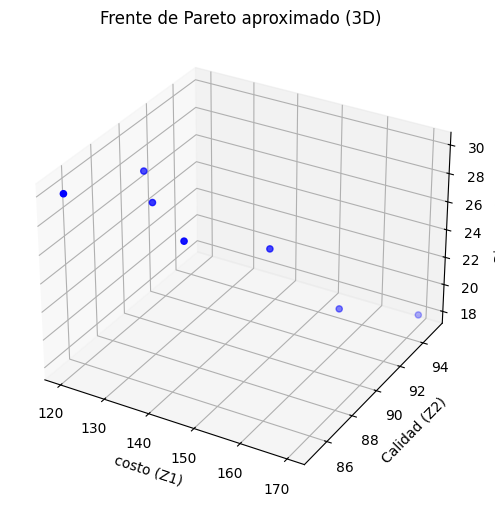

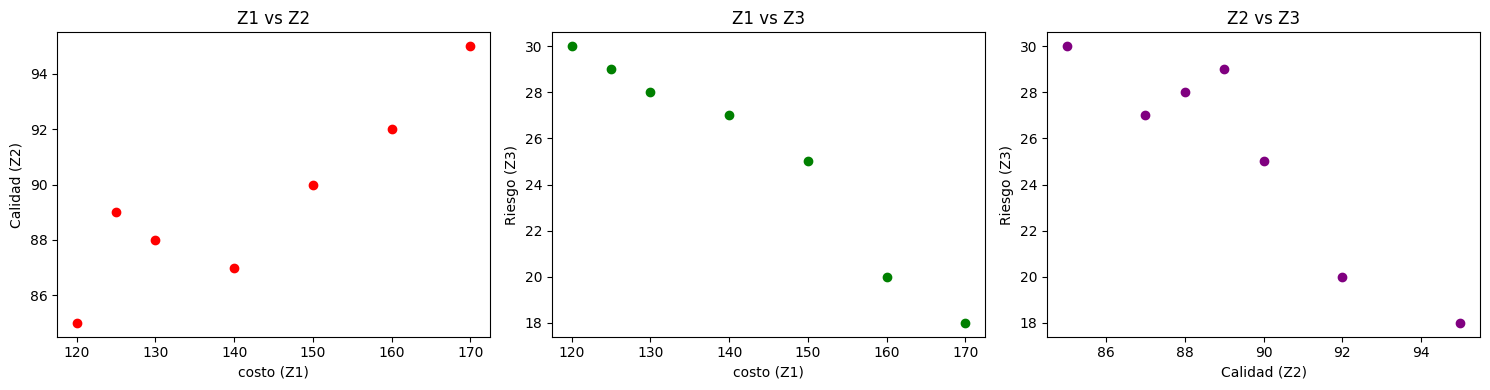

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Ejemplo de resultados de 7 soluciones (simulados)
# Sustituye estos valores con los que obtengas de Pyomo
Z1 = [120, 150, 130, 160, 140, 170, 125]  # costo
Z2 = [85, 90, 88, 92, 87, 95, 89]         # Calidad
Z3 = [30, 25, 28, 20, 27, 18, 29]         # Riesgo

# --- Gráfica 3D ---
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z1, Z2, Z3, c='blue', marker='o')

ax.set_xlabel('costo (Z1)')
ax.set_ylabel('Calidad (Z2)')
ax.set_zlabel('Riesgo (Z3)')
ax.set_title('Frente de Pareto aproximado (3D)')

plt.show()

# --- Proyecciones 2D ---
plt.figure(figsize=(15,4))

# Z1 vs Z2
plt.subplot(1,3,1)
plt.scatter(Z1, Z2, c='red')
plt.xlabel('costo (Z1)')
plt.ylabel('Calidad (Z2)')
plt.title('Z1 vs Z2')

# Z1 vs Z3
plt.subplot(1,3,2)
plt.scatter(Z1, Z3, c='green')
plt.xlabel('costo (Z1)')
plt.ylabel('Riesgo (Z3)')
plt.title('Z1 vs Z3')

# Z2 vs Z3
plt.subplot(1,3,3)
plt.scatter(Z2, Z3, c='purple')
plt.xlabel('Calidad (Z2)')
plt.ylabel('Riesgo (Z3)')
plt.title('Z2 vs Z3')

plt.tight_layout()
plt.show()

# Análisis y Discusión Adiciona

Evalúe cómo afectaría al diseño de la red logística el cambio de importancia re-
lativa entre los objetivos (por ejemplo, si el costo total fuera significativamente
más importante que la cobertura o el tiempo de entrega).
* En este caso, como se hace una inspección a todos los clientes, la calidad da muy igual porque siempre va a ser la misma en todas las ocasiones. Ya para las otras dos variables, si se prioriza minimizar el costo, los puede llegar a enviar por lugares muy peligrosos, poniendo en riesgo a los equipos. Por otro lado, si se prioriza minimizar el riesgo, les puede llegar a salir muy caro a la compañía hacer toda la ruta.

Identifique claramente la solución de compromiso que considera más equilibra-
da, justificando su elección con base en criterios específicos.

* Nosotros priorizaríamos enviar a los equipos por los lugares más seguros, entonces usaría 0.4 como multiplicador para el costo, 0.6 para el riesgo y dejaría en 0.0 para la calidad porque esa siempre va a ser la misma. Esto prioriza la vida del equipo pero mantiene el costo adecuado.